In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
import numpy as np

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Multivariate TS using VAR

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YoutubeLI/master/dataset/appliance_energy_usage.csv', index_col=0,parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T_out        19735 non-null  float64
 3   Press_mm_hg  19735 non-null  float64
 4   RH_out       19735 non-null  float64
 5   Windspeed    19735 non-null  float64
 6   Tdewpoint    19735 non-null  float64
 7   Visibility   19735 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 1.4 MB


In [4]:
df.head(5)

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Visibility
date,,,,,,,,
2016-01-11 17:00:00,60,30,6.600000,733.5,92.0,7.000000,5.3,63.000000
2016-01-11 17:10:00,60,30,6.483333,733.6,92.0,6.666667,5.2,59.166667
2016-01-11 17:20:00,50,30,6.366667,733.7,92.0,6.333333,5.1,55.333333
2016-01-11 17:30:00,50,40,6.250000,733.8,92.0,6.000000,5.0,51.500000
2016-01-11 17:40:00,60,40,6.133333,733.9,92.0,5.666667,4.9,47.666667


In [5]:
df_hourly = df.resample('1H').mean()

In [6]:
color_list = ["blue", "orange", "green", 
              "red", "purple", "brown", "pink",
              "gray", "olive", "cyan"]


def visualize(data):
  features = list(data.select_dtypes(include=[np.number]).columns.values)
  feature_size = len(features)
  fig, axes = plt.subplots(
      nrows=int(np.ceil(feature_size/2)), 
      ncols = 2,
      figsize=(14,feature_size*2),
      dpi=80,
      facecolor="w",
      edgecolor="k"
  )

  for i in range(feature_size):
     key = features[i]
     c = color_list[i%(len(color_list))]
     t_data = data[key]
     t_data.head()
     ax = t_data.plot(
         ax=axes[i//2, i%2],
         color=c,
         title="{}".format(key),
         rot=25, 
     )
     ax.legend([key])

  plt.tight_layout()

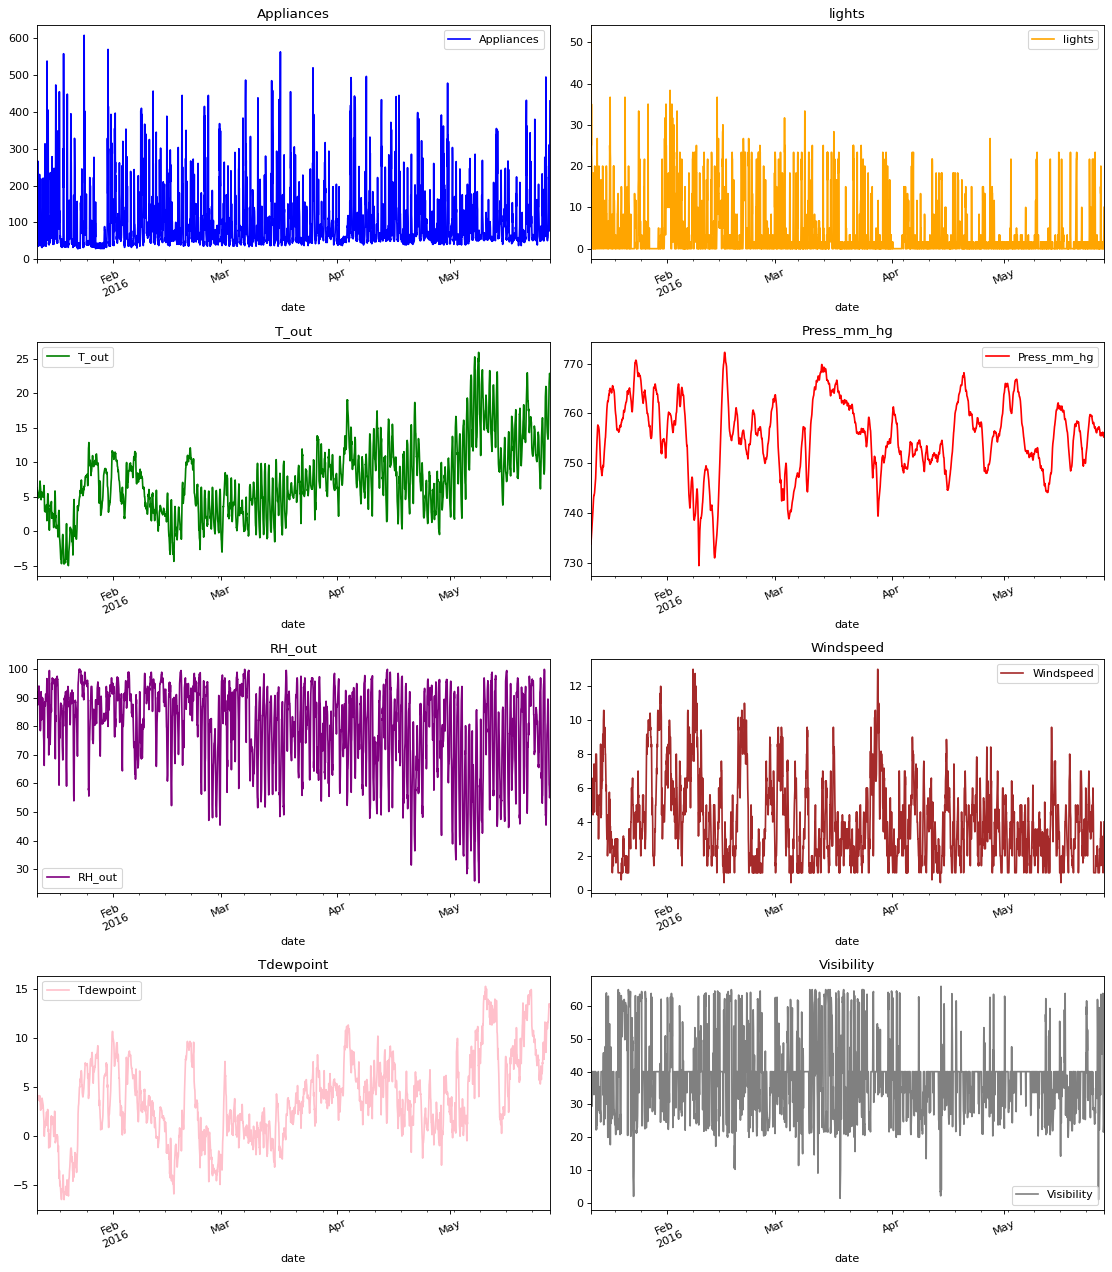

In [7]:
visualize(df_hourly)

#### Stationarity test



In [8]:
# ADF Test
for i in range(len(df_hourly.columns)):
  result = adfuller(df_hourly[df_hourly.columns[i]])

  if (result[1] > 0.05):
    print('{} - Series is not Stationarity'.format(df_hourly.columns[i]))
  else:
    print('{} - Series is Stationarity'.format(df_hourly.columns[i]))

Appliances - Series is Stationarity
lights - Series is Stationarity
T_out - Series is Stationarity
Press_mm_hg - Series is Stationarity
RH_out - Series is Stationarity
Windspeed - Series is Stationarity
Tdewpoint - Series is Stationarity
Visibility - Series is Stationarity


In [9]:
#Granger Casuality test

max_lags = 8
y='Appliances'

for i in range(len(df_hourly.columns)-1):
  results = grangercausalitytests(df_hourly[[y,df_hourly.columns[i+1]]], maxlag=max_lags, verbose=False)
  p_values = [round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
  print(' Column - {}: P_Values - {}'.format(df_hourly.columns[i+1], p_values))

 Column - lights: P_Values - [0.1451, 0.0005, 0.0001, 0.0002, 0.0001, 0.0001, 0.0006, 0.0012]
 Column - T_out: P_Values - [0.002, 0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0]
 Column - Press_mm_hg: P_Values - [0.0985, 0.1956, 0.0351, 0.0016, 0.0, 0.0001, 0.0, 0.0]
 Column - RH_out: P_Values - [0.0, 0.0004, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0]
 Column - Windspeed: P_Values - [0.0004, 0.0041, 0.0094, 0.0082, 0.0163, 0.0119, 0.0009, 0.0002]
 Column - Tdewpoint: P_Values - [0.4348, 0.4494, 0.5005, 0.3887, 0.05, 0.0694, 0.0992, 0.1152]
 Column - Visibility: P_Values - [0.7071, 0.5372, 0.7338, 0.8265, 0.544, 0.3324, 0.2521, 0.3465]


In [10]:
df_input = df_hourly[['Appliances', 'T_out', 'Windspeed']]

In [11]:
df_input

,Appliances,T_out,Windspeed
date,,,
2016-01-11 17:00:00,55.000000,6.308333,6.166667
2016-01-11 18:00:00,176.666667,5.941667,5.416667
2016-01-11 19:00:00,173.333333,6.000000,6.000000
2016-01-11 20:00:00,125.000000,6.000000,6.000000
2016-01-11 21:00:00,103.333333,5.833333,6.000000
...,...,...,...
2016-05-27 14:00:00,101.666667,21.916667,2.000000
2016-05-27 15:00:00,76.666667,22.216667,2.000000
2016-05-27 16:00:00,135.000000,22.883333,2.416667


In [12]:
train = df_input[:int(0.9*(len(df_input)))]
test = df_input[int(0.9*(len(df_input))):]

In [13]:
train.shape

(2961, 3)

In [14]:
test.shape

(329, 3)

In [15]:
model = VAR(train, freq='1H')
for i in range(48):
  results = model.fit(i+1)
  print('Order = ', i+1)
  print('AIC: ', results.aic)
  print('BIC: ', results.bic)

Order =  1
AIC:  7.126785098024289
BIC:  7.151080819162065
Order =  2
AIC:  6.13876916892782
BIC:  6.181298651759994
Order =  3
AIC:  6.019982255185912
BIC:  6.0807557708377455
Order =  4
AIC:  5.960526790759722
BIC:  6.03955461973309
Order =  5
AIC:  5.908069667837071
BIC:  6.005362100022209
Order =  6
AIC:  5.891197292905783
BIC:  6.006764627593055
Order =  7
AIC:  5.85225035501184
BIC:  5.986102900903522
Order =  8
AIC:  5.841915871050664
BIC:  5.994063946272741
Order =  9
AIC:  5.827889041110309
BIC:  5.998342973224303
Order =  10
AIC:  5.825120732509795
BIC:  6.013890858524602
Order =  11
AIC:  5.791083147024334
BIC:  5.998179813408081
Order =  12
AIC:  5.783228495344559
BIC:  6.008662058036487
Order =  13
AIC:  5.764122425516564
BIC:  6.00790324993892
Order =  14
AIC:  5.7545168062341
BIC:  6.016655267304056
Order =  15
AIC:  5.745057263179904
BIC:  6.025563745321491
Order =  16
AIC:  5.734159567395153
BIC:  6.033044464551212
Order =  17
AIC:  5.734437324119505
BIC:  6.0517110397

In [16]:
model.select_order(48).summary()

,AIC,BIC,FPE,HQIC
0,13.82,13.83,1.005e+06,13.82
1,7.139,7.163,1260.,7.148
2,6.149,6.192,468.3,6.165
3,6.031,6.093,416.2,6.053
4,5.970,6.050,391.7,5.999
5,5.917,6.015,371.3,5.952
6,5.902,6.019,365.7,5.944
7,5.863,5.999*,351.9,5.912
8,5.852,6.006,348.1,5.908
9,5.837,6.010,342.9,5.900


In [17]:
model = VAR(train, freq='1H')
results = model.fit(7)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, May, 2021
Time:                     03:41:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.98610
Nobs:                     2954.00    HQIC:                   5.90043
Log likelihood:          -21152.4    FPE:                    348.017
AIC:                      5.85225    Det(Omega_mle):         340.356
--------------------------------------------------------------------
Results for equation Appliances
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                37.865935         3.448219           10.981           0.000
L1.Appliances         0.451436         0.018470           24.442           0.000
L1.T_out              2.328238         2.534185        

In [18]:
lag = results.k_ar

In [19]:
results.forecast(train.values[-lag:], steps=5)

array([[44.34598018,  8.92651619,  3.99333186],
       [33.70923187,  8.81719814,  4.13871016],
       [38.32344216,  9.01953267,  4.188856  ],
       [53.39756915,  9.3356185 ,  4.31429082],
       [60.93798924,  9.56974211,  4.40093836]])

In [20]:
test[0:5]

,Appliances,T_out,Windspeed
date,,,
2016-05-14 02:00:00,60.000000,8.891667,3.166667
2016-05-14 03:00:00,60.000000,8.725000,2.833333
2016-05-14 04:00:00,60.000000,8.775000,4.416667
2016-05-14 05:00:00,56.666667,8.683333,5.000000
2016-05-14 06:00:00,63.333333,8.716667,5.000000


In [21]:
df_coef = pd.DataFrame([results.params['Appliances'], results.pvalues['Appliances']]).T

In [23]:
df_coef.columns = ['coeff', 'pval']

In [27]:
df_coef.query('pval < 0.05')
df_coef['valid'] = np.where(df_coef['pval'] < 0.05,1,0)

In [28]:
df_coef

,coeff,pval,valid
const,37.865935,4.701032e-28,1
L1.Appliances,0.451436,6.138160e-132,1
L1.T_out,2.328238,3.582355e-01,0
L1.Windspeed,2.268735,2.564126e-01,0
L2.Appliances,0.222279,4.255512e-28,1
L2.T_out,-4.372626,4.302427e-01,0
L2.Windspeed,-1.481847,6.603327e-01,0
L3.Appliances,-0.019489,3.454670e-01,0
L3.T_out,5.606923,3.952787e-01,0
L3.Windspeed,0.184615,9.598961e-01,0


In [30]:
coeff_arr = df_coef['coeff'][1:].values

In [31]:
in_arr = train[-lag:][::-1].stack().to_frame().T.values

In [32]:
in_arr

array([[ 63.33333333,   9.33333333,   4.        ,  58.33333333,
          9.79166667,   5.75      ,  61.66666667,  10.46666667,
          7.58333333,  55.        ,  11.85      ,   6.83333333,
         63.33333333,  14.11666667,   6.58333333, 120.        ,
         17.06666667,   8.16666667, 208.33333333,  19.33333333,
          9.        ]])

In [33]:
in_arr.shape

(1, 21)

In [34]:
#Next forecast
np.dot(in_arr, coeff_arr)+ df_coef['coeff'][:1].values

array([44.34598018])

## Auto Time series

In [67]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YoutubeLI/master/dataset/nyc_energy_consumption.csv', index_col=0,parse_dates=True)

In [39]:
# !pip3 install auto-ts
# !pip install tscv

In [68]:
df

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0000,46.13
2012-01-01 01:00:00,4752.1,0.0000,45.89
2012-01-01 02:00:00,4542.6,0.0000,45.04
2012-01-01 03:00:00,4357.7,0.0000,45.03
2012-01-01 04:00:00,4275.5,0.0000,42.61
...,...,...,...
2017-08-12 02:00:00,NaN,0.0000,70.84
2017-08-12 03:00:00,NaN,0.0000,70.57
2017-08-12 04:00:00,NaN,0.0000,69.89


In [78]:
df["demand"] = df["demand"].fillna(method="ffill")
df["temp"] = df["temp"].fillna(method="ffill")
df["precip"] = df["precip"].fillna(method="ffill")

In [81]:
df.query('temp != temp')

,demand,precip,temp
timeStamp,,,


In [82]:
df_monthly = df.resample('M').mean().reset_index()

In [83]:
df_monthly.isnull().any()

timeStamp    False
demand       False
precip       False
temp         False
dtype: bool

In [84]:
train = df_monthly[(df_monthly["timeStamp"] >= '2012-01-01') & (df_monthly["timeStamp"] <= '2017-04-30')]
test = df_monthly[df_monthly["timeStamp"] > '2017-04-30']

In [86]:
train = train.reset_index()

In [87]:
test.shape, train.shape

((4, 4), (64, 5))

In [88]:
train

,index,timeStamp,demand,precip,temp
0,0,2012-01-31,5757.495833,0.003116,37.174288
1,1,2012-02-29,5622.331609,0.001650,40.448046
2,2,2012-03-31,5479.919198,0.001179,49.607917
3,3,2012-04-30,5368.945833,0.003959,54.255903
4,4,2012-05-31,5867.896102,0.005064,64.188078
...,...,...,...,...,...
59,59,2016-12-31,5720.892685,0.002509,37.730417
60,60,2017-01-31,5737.960759,0.003749,37.063629
61,61,2017-02-28,5611.677426,0.002085,40.434955
62,62,2017-03-31,5660.977832,0.004687,38.599489


In [75]:
from auto_ts import auto_timeseries

In [91]:
model = auto_timeseries(score_type='rmse',time_interval='D',
                        non_seasonal_pdq=(2,1,2),
                        seasonality=True,
                        seasonal_period=12,
                        mopdel_type=['best'],
                        verbose=2)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Error: Stationary test failed. Data must be np.array. Check your input and try stationary test again
    Target variable given as = demand
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column: timeStamp sep: , target: demand
    Loaded pandas dataframe...
    pandas Dataframe loaded successfully. Shape of data set = (64, 2)


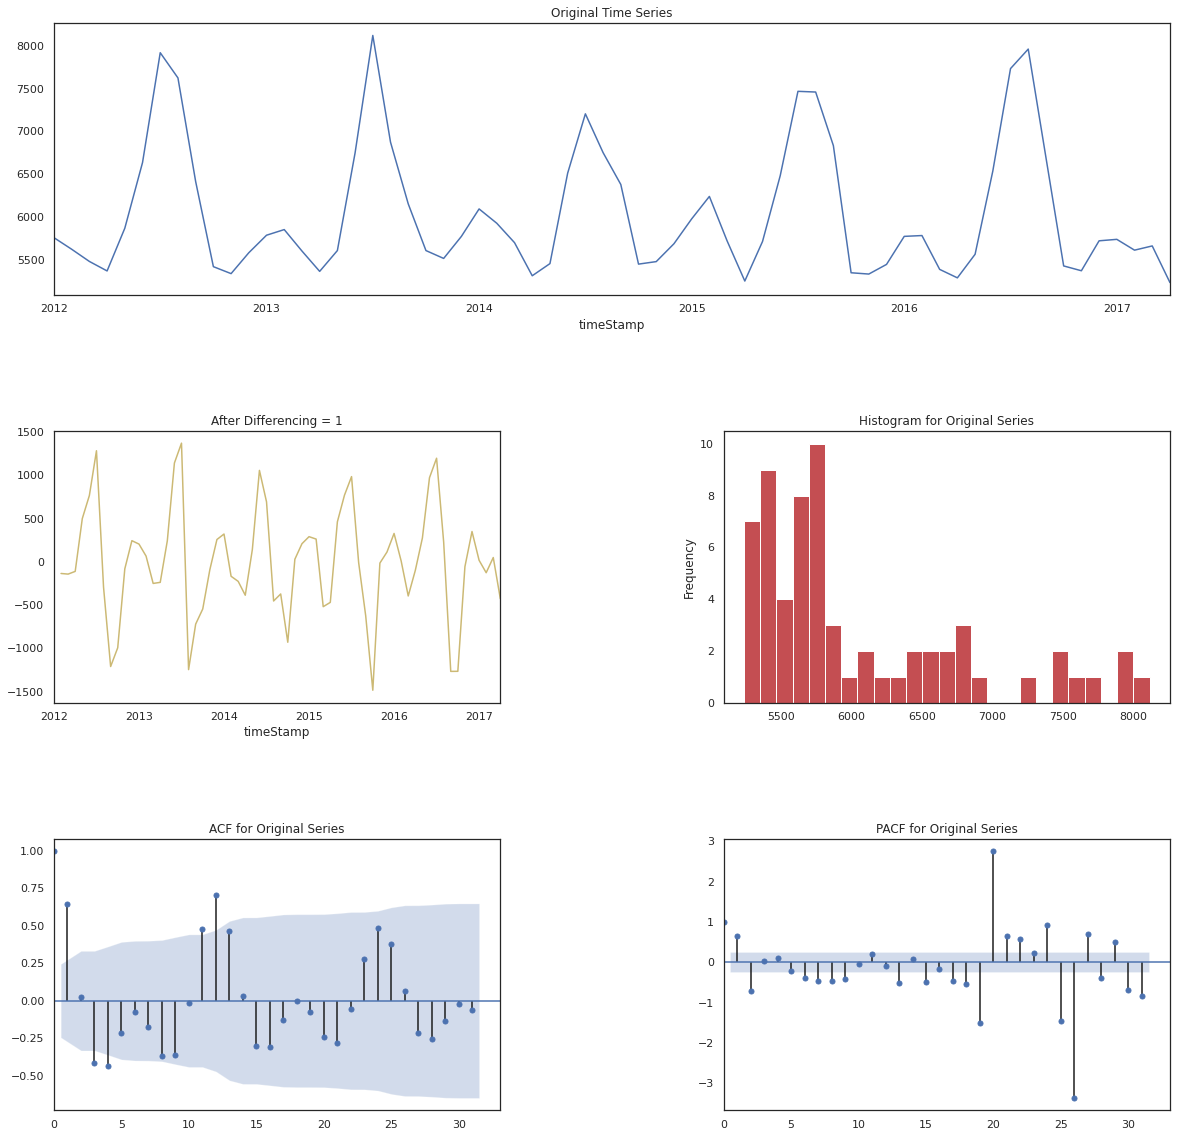

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: True
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 49 Test Shape: 5

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=530.863, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=530.364, Time=0.78 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=526.186, Time=0.87 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=528.863, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=526.402, Time=0.18 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=527.182, Time=0.75 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=nan sec
 AR

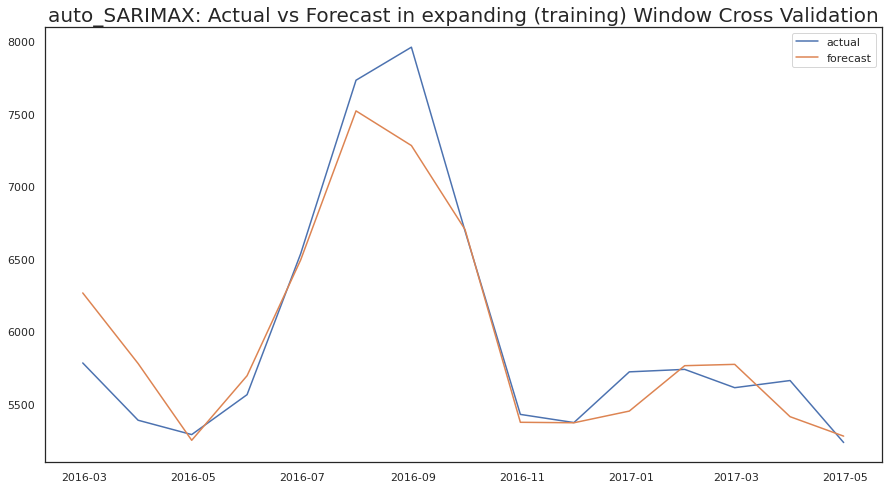

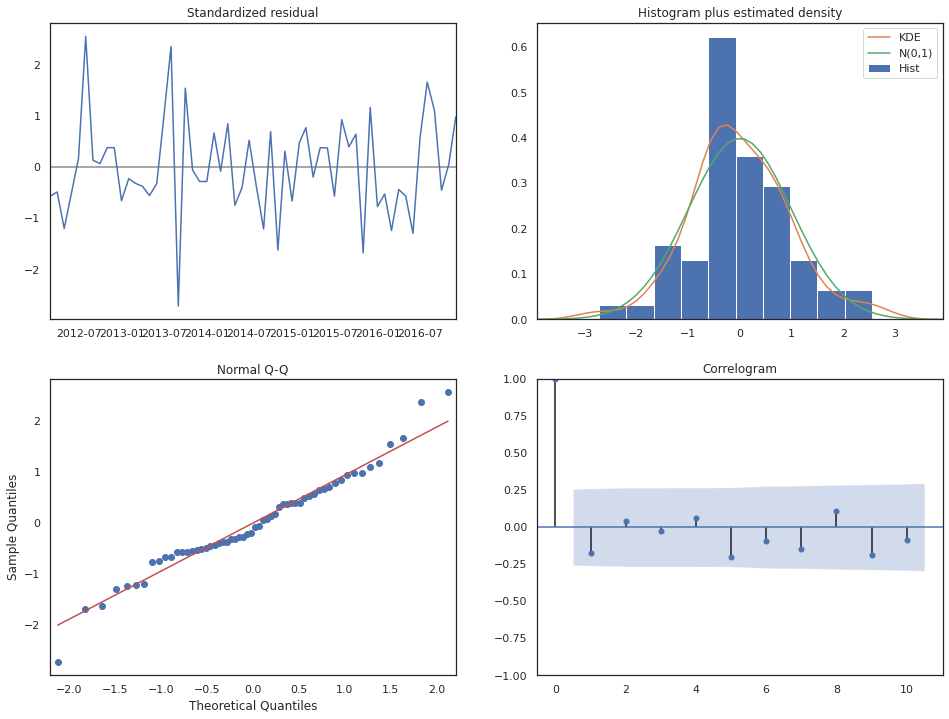

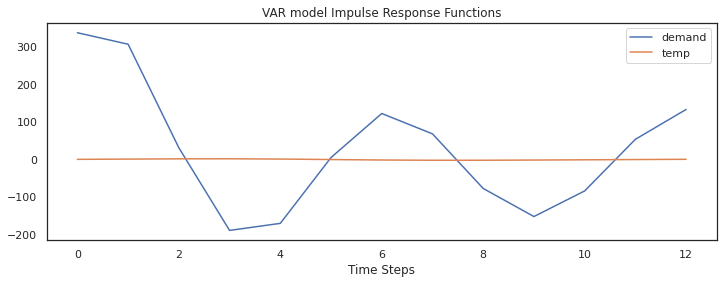

In [92]:
model.fit(traindata=train[['timeStamp', 'demand', 'temp']], 
          ts_column='timeStamp', target='demand', cv=3)

In [93]:
model.get_leaderboard()

,name,rmse
0,auto_SARIMAX,261.599368
1,VAR,485.380153


In [94]:
model.get_cv_scores()

,Model,CV Scores
0,auto_SARIMAX,285.121686
1,auto_SARIMAX,318.701389
2,auto_SARIMAX,180.975031
3,VAR,598.557955
4,VAR,636.406977
5,VAR,221.175526


In [95]:
results = model.get_ml_dict()

In [96]:
results

defaultdict(<function auto_ts.auto_timeseries.fit.<locals>.<lambda>>,
            {'VAR': defaultdict(<function auto_ts.auto_timeseries.fit.<locals>.<lambda>>,
                         {'forecast': [array([6201.13063557, 6236.08435925, 5940.48070294, 5721.09750532,
                                  5867.95958463]),
                           array([7110.77311575, 6862.25244354, 6168.4750122 , 5682.03588964,
                                  5679.1595847 ]),
                           array([5741.68278677, 5967.962496  , 5800.86056418, 5535.48069375,
                                  5607.26909936])],
                          'model': <statsmodels.tsa.statespace.varmax.VARMAXResultsWrapper at 0x7f25332e9410>,
                          'model_build': <auto_ts.models.ar_based.build_var.BuildVAR at 0x7f254cf59890>,
                          'rmse': [598.5579552136677,
                           636.4069770572263,
                           221.17552610340238]}),
             'auto_SARIMAX